# Falcon 9 - Will the first stage land successfully?

### Installations

In [1]:
# !pip3 install beautifulsoup4
# !pip3 install requests
# !pip install sql
# !pip install sqlalchemy==1.3.9
# !pip install ipython-sql
# !pip install folium
# !pip install js

# Data Collection

### REST API

#### Imports

In [2]:
import requests
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

# Setting display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#### Get data from the API and convert it into a DataFrame

In [3]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
data_api = pd.json_normalize(response.json())

#### Editing the SpaceX dataframe

In [4]:
# Selecting features
data_api = data_api[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# Filtering out falcon rockets with multiple cores / payloads
data_api = data_api[data_api['cores'].map(len)==1]
data_api = data_api[data_api['payloads'].map(len)==1]
data_api['cores'] = data_api['cores'].map(lambda x : x[0])
data_api['payloads'] = data_api['payloads'].map(lambda x : x[0])

# Converting date format
data_api['date'] = pd.to_datetime(data_api['date_utc']).dt.date
data_api = data_api[data_api['date'] <= datetime.date(2020, 11, 13)]
data_api.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


#### Getting Booster Version by hashed key

In [5]:
BoosterVersion = []
for rocket_id in data_api['rocket']:
    if rocket_id:
        response = requests.get("https://api.spacexdata.com/v4/rockets/" + str(rocket_id)).json()
        BoosterVersion.append(response['name'])
    else:
        BoosterVersion.append(None)

#### Getting Launch Site, Latitude and Longitude by hashed key

In [6]:
Longitude = []
Latitude = []
LaunchSite = []

for site_id in data_api['launchpad']:
    if site_id:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/" + str(site_id)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])
    else:
        Longitude.append(None)
        Latitude.append(None)
        LaunchSite.append(None)

#### Getting payload data by hashed key

In [7]:
PayloadMass = []
Orbit = []

for load in data_api['payloads']:
    if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/" + load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
    else:
        PayloadMass.append(None)
        Orbit.append(None)

#### Getting core data

In [8]:
Block = []
ReusedCount = []
Serial = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []

for core in data_api['cores']:
    if core['core'] is not None:
        response = requests.get("https://api.spacexdata.com/v4/cores/" + core['core']).json()        
        Block.append(response['block'])
        ReusedCount.append(response['reuse_count'])
        Serial.append(response['serial'])
    else:
        Block.append(None)
        ReusedCount.append(None)
        Serial.append(None)
    Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
    Flights.append(core['flight'])
    GridFins.append(core['gridfins'])
    Reused.append(core['reused'])
    Legs.append(core['legs'])
    LandingPad.append(core['landpad'])

#### Creating a data frame from the preprocessed data

In [9]:
launch_dict = {'FlightNumber': list(data_api['flight_number']),
                'Date': list(data_api['date']),
                'BoosterVersion':BoosterVersion,
                'PayloadMass':PayloadMass,
                'Orbit':Orbit,
                'LaunchSite':LaunchSite,
                'Outcome':Outcome,
                'Flights':Flights,
                'GridFins':GridFins,
                'Reused':Reused,
                'Legs':Legs,
                'LandingPad':LandingPad,
                'Block':Block,
                'ReusedCount':ReusedCount,
                'Serial':Serial,
                'Longitude': Longitude,
                'Latitude': Latitude
              }

data = pd.DataFrame(launch_dict)

#### Filter out Falcon 1 rows and reset `FlightNumber`

In [10]:
data = data[data['BoosterVersion'] == 'Falcon 9']
data.loc[:,'FlightNumber'] = list(range(1, data.shape[0]+1))
data.reset_index(drop=True, inplace=True)

#### Data Wrangling: Dealing with missing `PayloadMass` values

In [11]:
mean_payload_mass = data['PayloadMass'].mean()
data['PayloadMass'].replace(np.nan, mean_payload_mass, inplace=True)

In [12]:
# Checking the results
data.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

### Web Scraping

#### Additional imports

In [13]:
import sys
from bs4 import BeautifulSoup
import re
import unicodedata

#### Helper functions

In [14]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


#### Using the `static_url` to get the web page content

In [15]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url)
soup = BeautifulSoup(response.text, 'html.parser')

#### Extract all column names from the HTML table header

In [16]:
html_tables = soup.find_all('table')
column_names = []
for header in html_tables[2].find_all('th'):
    name = extract_column_from_header(header)
    if name is not None and len(name) > 0:
        column_names.append(name)

#### Create a data frame by parsing the launch HTML tables

In [17]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [18]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        # check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        # if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            launch_dict['Flight No.'].append(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            
            # Time value
            time = datatimelist[1]
            launch_dict['Time'].append(time)
              
            # Booster version
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            
            # Launch Site
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            
            # Payload
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            
            # Payload Mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            # Orbit
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            
            # Customer
            if row[6].string:
                customer = row[6].string
            else:
                customer = row[6].a.string
            launch_dict['Customer'].append(customer)
            
            # Launch outcome
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            
            # Booster landing
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

df = pd.DataFrame(launch_dict)
df["Date"] = pd.to_datetime(df["Date"]).dt.date

# Data Wrangling

#### Calculate the number of launches on each site

In [19]:
data['LaunchSite'].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

#### Calculate the number and occurrence of each orbit

In [20]:
data['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

#### Calculate the number and occurence of mission outcome per orbit type

In [21]:
landing_outcomes = data['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

#### Bad outcomes

In [22]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

#### Landing class

In [23]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in data['Outcome']]
data['Class']=landing_class
data[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


# Exploratory Analysis

#### Imports

In [24]:
import csv, sqlite3

### SQL Tasks (using the data from the lab)

In [25]:
%load_ext sql
con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

101

#### Display the names of the unique launch sites in the space mission

In [26]:
%sql select DISTINCT("Launch_Site") from SPACEXTBL

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


#### Display 5 records where launch sites begin with the string 'CCA'

In [27]:
%sql select * from SPACEXTBL where "Launch_Site" like 'CCA%' limit 5

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing _Outcome
04-06-2010,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
08-12-2010,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
22-05-2012,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
08-10-2012,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
01-03-2013,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


#### Display the total payload mass carried by boosters launched by NASA (CRS)

In [28]:
%sql select sum("PAYLOAD_MASS__KG_") as "Total Payload Mass by NASA (CRS)" from SPACEXTBL where "Customer"='NASA (CRS)'

 * sqlite:///my_data1.db
Done.


Total Payload Mass by NASA (CRS)
45596


#### Display average payload mass carried by booster version F9 v1.1

In [29]:
%%sql
select avg("PAYLOAD_MASS__KG_") as "Average Payload Mass by F9 v1.1"
from SPACEXTBL
where "Booster_Version" like 'F9 v1.1%'

 * sqlite:///my_data1.db
Done.


Average Payload Mass by F9 v1.1
2534.6666666666665


#### List the date when the first succesful landing outcome in ground pad was acheived.

In [30]:
%sql select min(Date) as "First Success" from SPACEXTBL where "Landing _Outcome" like 'Success%'

 * sqlite:///my_data1.db
Done.


First Success
01-05-2017


#### List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

In [31]:
%%sql
select distinct("Booster_Version") from SPACEXTBL
where "Landing _Outcome" = 'Success (drone ship)'
and "PAYLOAD_MASS__KG_" between 4000 and 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


#### List the total number of successful and failure mission outcomes

In [32]:
%%sql
select substr("Mission_Outcome",1,7) as "Outcome", count("Mission_Outcome") as "Count"
from spacextbl group by substr("Mission_Outcome",1,7);

 * sqlite:///my_data1.db
Done.


Outcome,Count
Failure,1
Success,100


#### List the names of the booster_versions which have carried the maximum payload mass. Use a subquery

In [33]:
%%sql
select distinct("Booster_Version") from spacextbl
where "PAYLOAD_MASS__KG_" = (select max("PAYLOAD_MASS__KG_") from spacextbl);

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


#### List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.

In [34]:
%%sql
select substr("Date",4,2) as "Month", "Landing _Outcome", "Booster_Version", "Launch_Site"
from spacextbl
where substr("Date",7,4) = '2015' and
"Landing _Outcome" = "Failure (drone ship)";

 * sqlite:///my_data1.db
Done.


Month,Landing _Outcome,Booster_Version,Launch_Site
01,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
04,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


#### Rank the count of successful landing_outcomes between the date 04-06-2010 and 20-03-2017 in descending order.

In [35]:
%%sql
select "Landing _Outcome", count("Landing _Outcome") as "Count"
from spacextbl
where "Landing _Outcome" like 'Success%' and
"Date" between '04-06-2010' and '20-03-2017'
group by "Landing _Outcome"
order by count("Landing _Outcome") desc;

 * sqlite:///my_data1.db
Done.


Landing _Outcome,Count
Success,20
Success (drone ship),8
Success (ground pad),6


### Using Pandas and Matplotlib

#### Imports

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Visualize the relationship between `FlightNumber` and `LaunchSite`

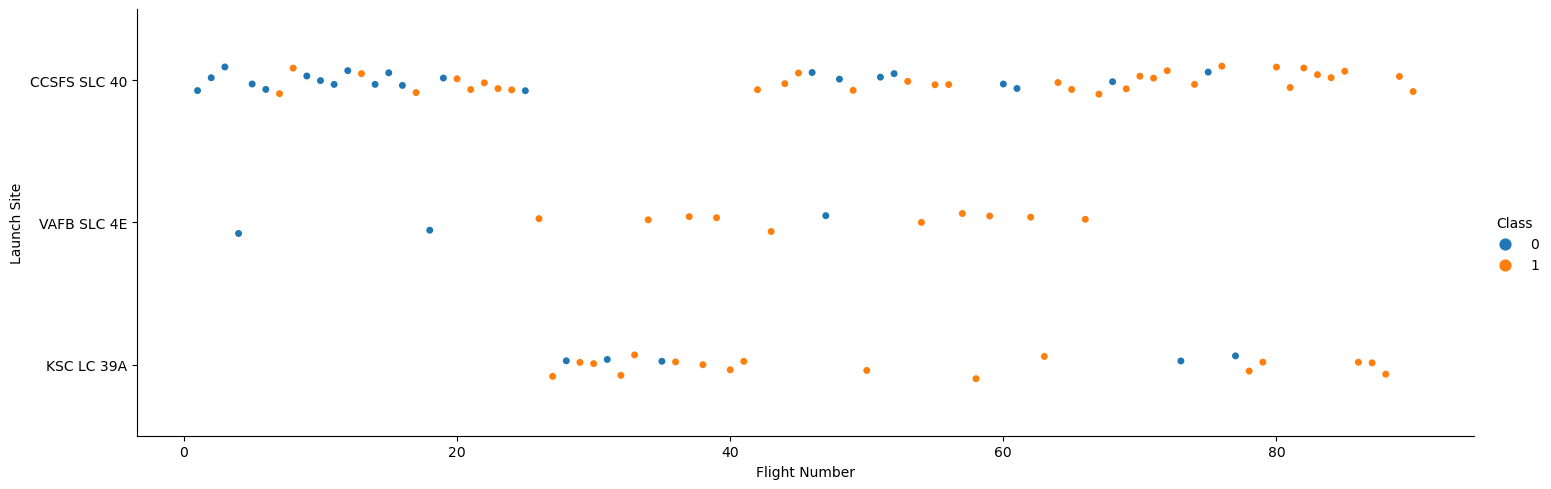

In [37]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data, aspect = 3)
plt.xlabel("Flight Number")
plt.ylabel("Launch Site")
plt.show()

#### Visualize the relationship between Payload and Launch Site

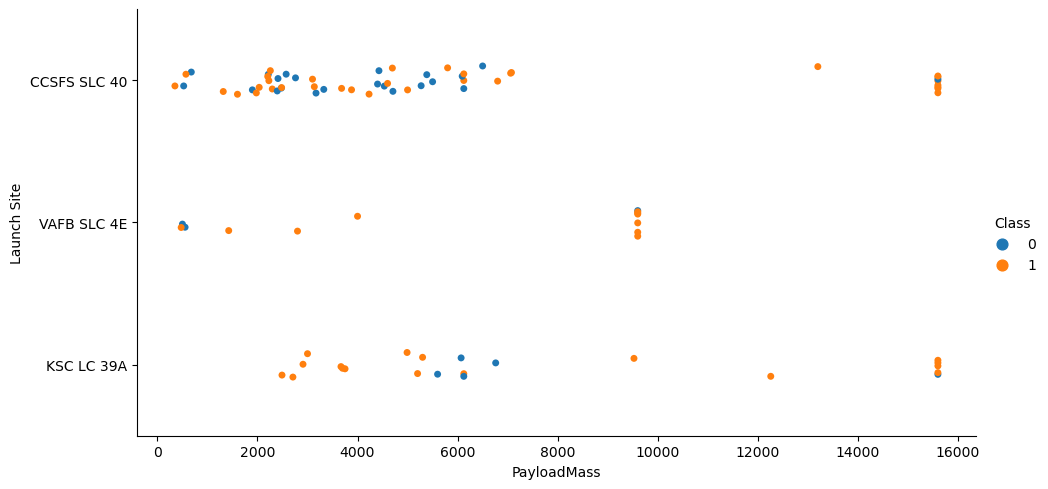

In [38]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data, aspect=2)
plt.xlabel("PayloadMass")
plt.ylabel("Launch Site")
plt.show()

#### Visualize the relationship between success rate of each orbit type

<AxesSubplot:xlabel='Orbit'>

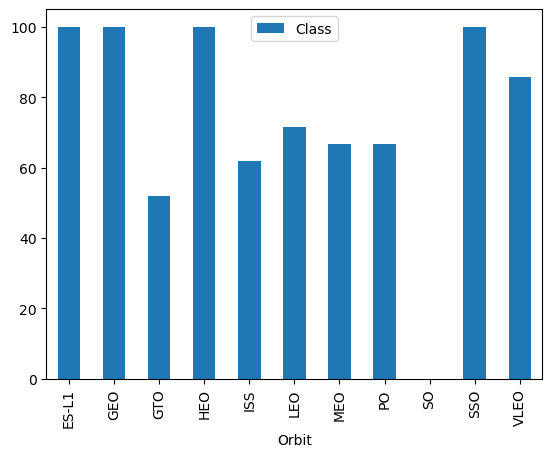

In [39]:
(data[["Orbit","Class"]].groupby("Orbit").mean()*100).plot(kind="bar")

#### Visualize the relationship between FlightNumber and Orbit type

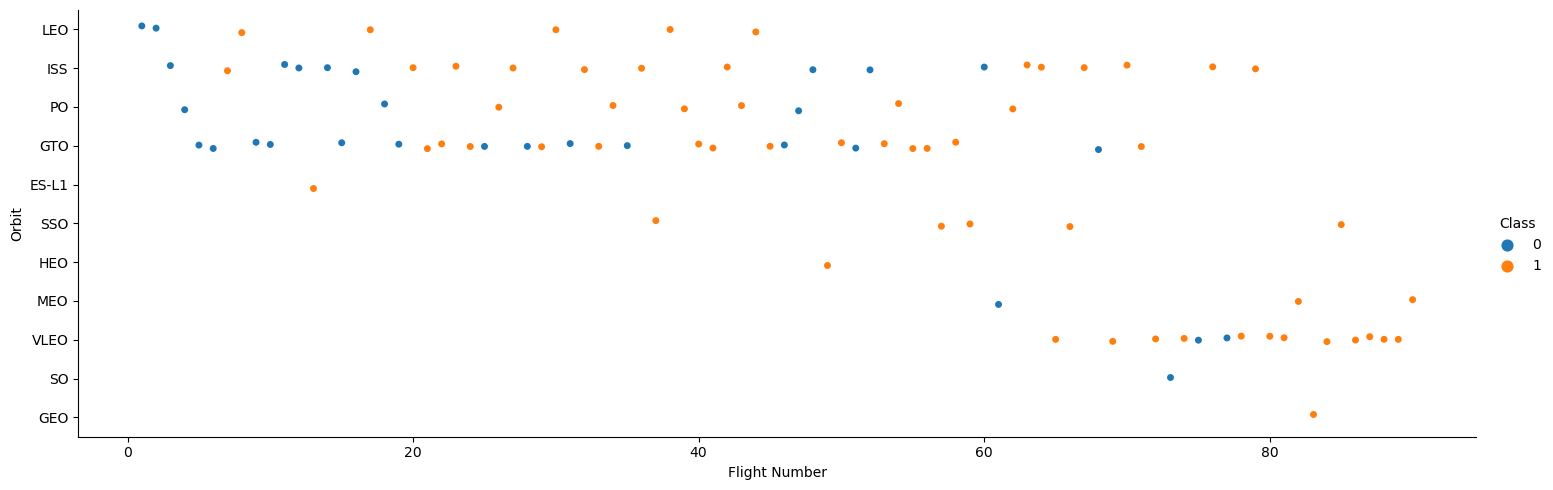

In [40]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data, aspect=3)
plt.xlabel("Flight Number")
plt.ylabel("Orbit")
plt.show()

#### Visualize the relationship between Payload and Orbit type

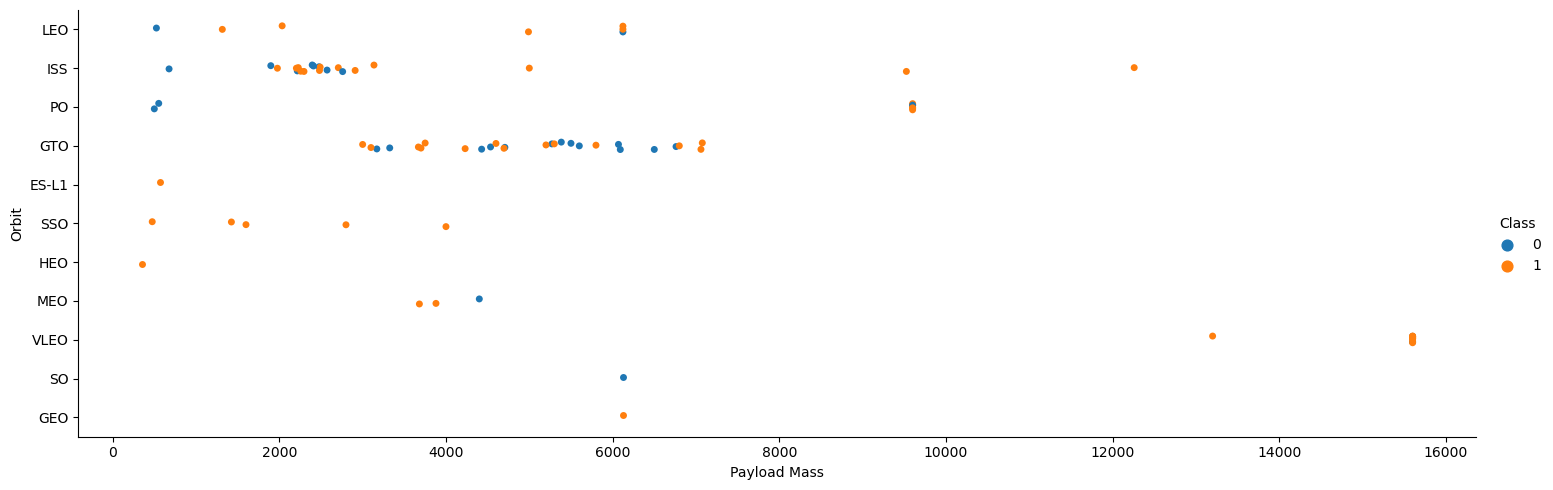

In [41]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data, aspect=3)
plt.xlabel("Payload Mass")
plt.ylabel("Orbit")
plt.show()

#### Visualize the launch success yearly trend

<AxesSubplot:xlabel='Year'>

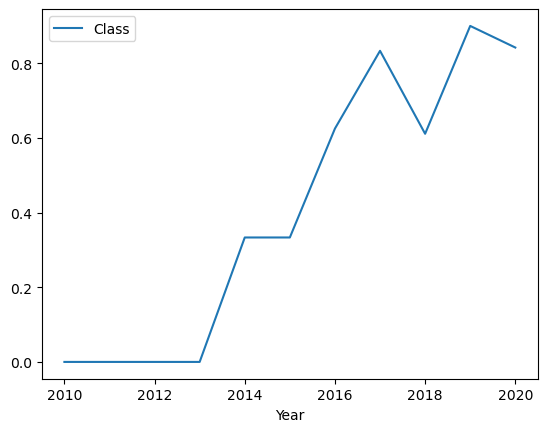

In [42]:
data["Year"] = pd.DatetimeIndex(data['Date']).year
data[["Year","Class"]].groupby("Year").mean().sort_index().plot()

# Feature Engineering

In [43]:
features = data[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


#### Create dummy variables to categorical columns

In [44]:
categorical = ["Orbit", "LaunchSite", "LandingPad", "Serial"]
features_one_hot = pd.get_dummies(features, columns=categorical)
features_one_hot

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,2,True,True,True,5.0,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
86,87,15600.000000,3,True,True,True,5.0,13,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
87,88,15600.000000,6,True,True,True,5.0,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
88,89,15600.000000,3,True,True,True,5.0,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Cast all numeric columns to `float64`

In [45]:
features_one_hot = features_one_hot.astype('float64')

# Launch Sites Locations Analysis with Folium (using the data from the lab)

#### Imports

In [46]:
import folium
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

#### Mark all launch sites on a map

In [47]:
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
spacex_df=pd.read_csv(URL)
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


#### Mark all launch sites on a map

In [48]:
##### Initial the map
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=4)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for index, record in launch_sites_df.iterrows():
    coordinate = [record["Lat"], record["Long"]]
    label = record["Launch Site"]
    circle = folium.Circle(coordinate, radius=50, color='#d35400', fill=True).add_child(folium.Popup(label))
    marker = folium.map.Marker(
        coordinate,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % label,
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)
site_map

#### Mark the success/failed launches for each site on the map

In [49]:
spacex_df["marker_color"] = ["green" if c == 1 else "red" for c in spacex_df["class"]]

marker_cluster = MarkerCluster()

# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    coordinate = [record["Lat"], record["Long"]]
    label = record["Launch Site"]
    color = record["marker_color"]
    marker = folium.map.Marker(
                coordinate,
                icon=folium.Icon(color=color, icon="info-sign"),
                popup=label
                )
    marker_cluster.add_child(marker)

site_map

#### Calculate the distances between a launch site to its proximities

In [50]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat: ',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

#### Distance via coordinates

In [51]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [52]:
# find coordinate of the closet coastline
coastline_lat = 28.5638
coastline_lon = -80.56804
launch_site_lat = launch_sites_df.loc[launch_sites_df["Launch Site"] == "CCAFS SLC-40", "Lat"].values[0]
launch_site_lon = launch_sites_df.loc[launch_sites_df["Launch Site"] == "CCAFS SLC-40", "Long"].values[0]
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

In [53]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
distance_marker = folium.Marker(
    [coastline_lat, coastline_lon],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color: #d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline)
    )
)
site_map.add_child(distance_marker)
site_map

In [54]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
points = [[launch_site_lat, launch_site_lon],[coastline_lat, coastline_lon]]
lines = folium.PolyLine(points, weight=1)
site_map.add_child(lines)
site_map

In [55]:
hw = [28.56396, -80.57087]
rw = [28.57208, -80.58526]
cm = [28.61105, -80.80753]
ls = [launch_site_lat, launch_site_lon]

for p in [hw, rw, cm]:
    distance = calculate_distance(p[0], p[1], ls[0], ls[1])
    distance_marker = folium.Marker(
        p,
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color: #d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance)
        )
    )
    site_map.add_child(distance_marker)
    site_map.add_child(folium.PolyLine([p, ls], weight=1))
    
site_map

# Machine Learning Prediction

#### Imports

In [56]:
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

#### Function for displaying a confusion matrix

In [57]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

#### Preparing the data from `features_one_hot` and `data['Class']`, and standardizing `X`

In [58]:
X = features_one_hot
Y = data['Class'].to_numpy()

transform = preprocessing.StandardScaler().fit(X)
X = transform.transform(X)

#### Preparing the train and test sets

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_train: (72, 80)
Shape of Y_train: (72,)
Shape of X_test: (18, 80)
Shape of Y_test: (18,)


### Logistic Regression

#### Training

In [60]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


#### Testing

In [61]:
logreg_acc = logreg_cv.score(X_test, Y_test)
print(f"Logistic Regression accuracy on the test set: {logreg_acc}")

Logistic Regression accuracy on the test set: 0.8333333333333334


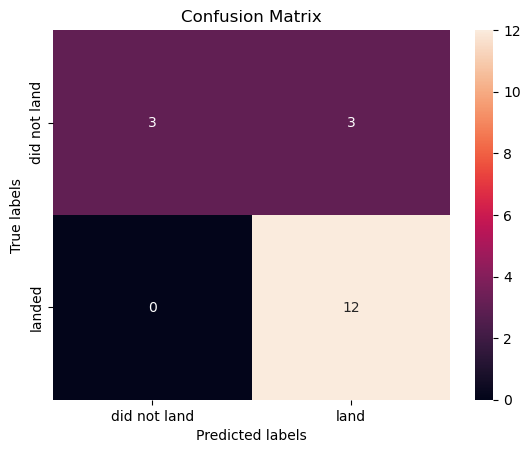

In [62]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Support Vector Machine (SVM)

#### Training

In [63]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


#### Testing

In [64]:
svm_acc = logreg_cv.score(X_test, Y_test)
print(f"SVM accuracy on the test set: {svm_acc}")

SVM accuracy on the test set: 0.8333333333333334


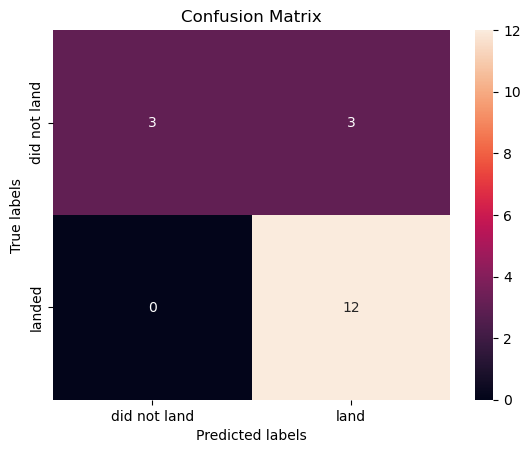

In [65]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Decision Tree

#### Training

In [66]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.875


#### Testing

In [67]:
tree_acc = tree_cv.score(X_test, Y_test)
print(f"Tree accuracy on the test set: {tree_acc}")

Tree accuracy on the test set: 0.4444444444444444


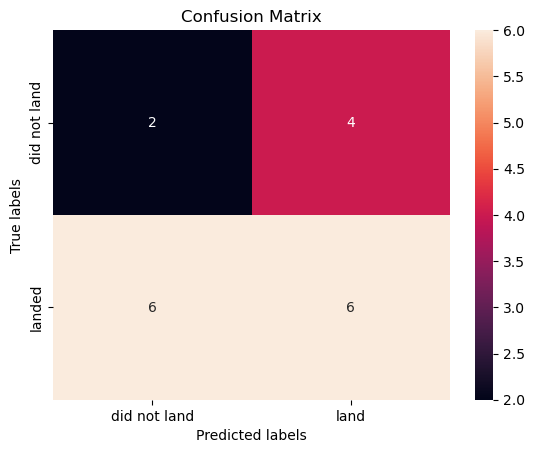

In [68]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### K-Nearest Neighbours (KNN)

#### Training

In [69]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


#### Testing

In [70]:
knn_acc = knn_cv.score(X_test, Y_test)
print(f"KNN accuracy on the test set: {knn_acc}")

KNN accuracy on the test set: 0.7777777777777778


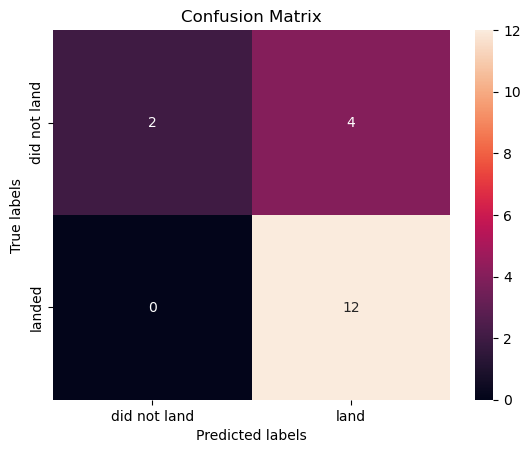

In [71]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Choosing the best classifier

<AxesSubplot:xlabel='Algorithm'>

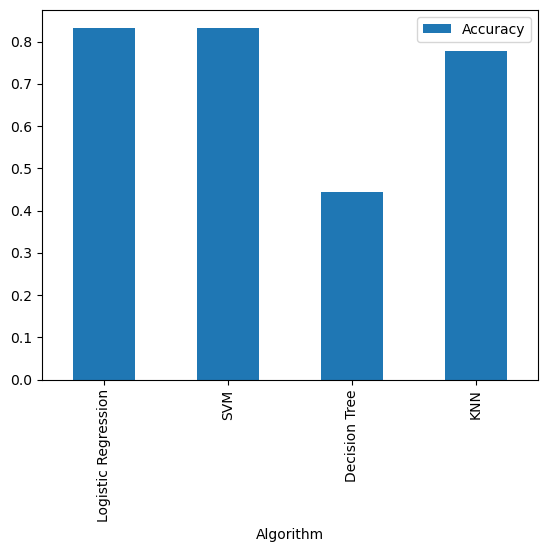

In [72]:
results_df = pd.DataFrame({
    "Algorithm": ["Logistic Regression","SVM","Decision Tree","KNN"],
    "Accuracy": [logreg_acc, svm_acc, tree_acc, knn_acc]
})
results_df.plot.bar(x="Algorithm")

We can see that the Decision Tree gave the best accuracy!

# END OF NOTEBOOK